In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime

import seaborn as sns
from scipy.optimize import minimize

In [25]:
sns.set()

In [173]:
ticker = "^FCHI"
start_date = "2000-01-01"
end_date = pd.Timestamp(datetime.date.today())

data = yf.download(ticker, start=start_date, end=end_date)["Close"]
data.columns = ["Close"]
data.index = pd.to_datetime(data.index)
data["return"] = np.log(data["Close"] / data["Close"].shift(1))
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [174]:
data.head()

,Close,return
Date,,
2000-01-04,5672.020020,-0.042347
2000-01-05,5479.700195,-0.034495
2000-01-06,5450.109863,-0.005415
2000-01-07,5539.609863,0.016288
2000-01-10,5646.120117,0.019045


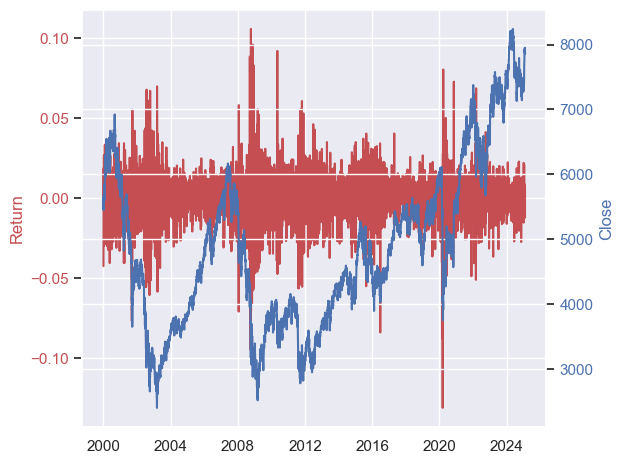

In [175]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

# First y-axis
ax1.plot(data.index, data["return"], color='r', label='Return')
ax1.set_ylabel('Return', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(data.index, data["Close"], color='b', label='Close')
ax2.set_ylabel('Close', color='b')
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout()
plt.show()


In [176]:
# Train/Test sets
data_train = data.loc["2008-10-15":"2022-07-26",]
data_test = data.loc["2022-07-27":"2024-06-11",]

In [177]:
print(data_train.describe())
print("-"*80)
print(data_test.describe())

             Close       return
count  3523.000000  3523.000000
mean   4601.299644     0.000153
std    1022.270616     0.013953
min    2519.290039    -0.130983
25%    3798.179932    -0.006099
50%    4463.000000     0.000580
75%    5318.609863     0.006855
max    7376.370117     0.096169
--------------------------------------------------------------------------------
             Close      return
count   480.000000  480.000000
mean   7180.258167    0.000472
std     588.624058    0.008826
min    5676.870117   -0.036484
25%    6858.330200   -0.004104
50%    7260.850098    0.000760
75%    7491.614990    0.005526
max    8239.990234    0.041504


In [178]:
# Historic VaR

def Var_Hist(data, alpha):
    return float(data.quantile(1 - alpha))

def Var_Hist_Bootstrap(data, alpha, B, alpha_IC, M):
    var = []
    for _ in range(M):
        index = np.random.choice(data.index, size=B, replace=False)  # Bootstrap sampling
        var.append(data.loc[index].quantile(1 - alpha))
    
    var = np.array(var)
    alpha_IC_bis = (1 - alpha_IC)/2
    b_inf = np.percentile(var, alpha_IC_bis * 100)  # Lower bound of confidence interval
    b_sup = np.percentile(var, (1-alpha_IC_bis) * 100)        # Upper bound of confidence interval

    return {'VaR': var.mean(),
                        f'IC_lower_{round(1 - alpha_IC, 2)}': [b_inf],
                        f'IC_upper_{alpha_IC}': [b_sup]}


In [179]:
VaR_train = Var_Hist(data_train[["return"]], alpha = 0.99)

C:\Users\DEBA\AppData\Local\Temp\ipykernel_6200\2650281103.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return float(data.quantile(1 - alpha))


In [180]:
VaR_train

-0.040850308593776974

In [181]:
VaR_train_Bootstrap = Var_Hist_Bootstrap(data_train[["return"]], alpha = 0.99, B = 252, alpha_IC = 0.90, M = 500)

In [182]:
VaR_train_Bootstrap

{'VaR': -0.03964715078508796,
 'IC_lower_0.1': [-0.05232925938688141],
 'IC_upper_0.9': [-0.029728427837316374]}

In [183]:
data_test["exceed_VaR"] = (data_test.loc[:,"return"] < VaR_train).astype(int)

C:\Users\DEBA\AppData\Local\Temp\ipykernel_6200\3846812421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test["exceed_VaR"] = (data_test.loc[:,"return"] < VaR_train).astype(int)


In [184]:
data_test["exceed_VaR"].sum()

0

In [185]:
import scipy.stats as st

def exceedance_test(data, VaR, alpha_exceed = 0.05):
        data["exceed_VaR"] = (data.loc[:,"return"] < VaR).astype(int)
        num_exceed = data["exceed_VaR"].sum()
        
        p_hat = num_exceed / len(data)
        z = st.norm.ppf(1 - alpha_exceed / 2)
        margin = z * np.sqrt(p_hat * (1 - p_hat) / len(data))
        return (p_hat - margin, p_hat + margin)

In [186]:
exceedance_test(data_test, VaR_train)

C:\Users\DEBA\AppData\Local\Temp\ipykernel_6200\1460026120.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["exceed_VaR"] = (data.loc[:,"return"] < VaR).astype(int)


(0.0, 0.0)

In [187]:
# VaR student
def f_skew_student(x, mu, sigma, gamma, nu):
    arg = (x-mu)/sigma
    arg2 = gamma*arg*np.sqrt((nu+1)/(arg**2 + nu))
    f = st.t.pdf(x, df = nu, loc = mu, scale = sigma)
    F = st.t.cdf(arg2, df = nu + 1)
    return 2*f*F

def log_likelihood(theta, x):
    mu, sigma, gamma, nu = theta
    pdf_values = f_skew_student(x, mu, sigma, gamma, nu)
    log_lik = np.sum(np.log(pdf_values))
    return -log_lik

def optimize_parameters(x):
    """Optimize parameters using 'trust-constr' method"""
    # Initial guess for [mu, sigma, gamma, nu]
    theta_init = [np.mean(x), np.std(x), 0, 5]  # [mu, sigma, gamma, nu]
    
    # Bounds: sigma > 0 and nu > 1
    bounds = [(None, None), (1e-6, None), (None, None), (1, None)]  # bounds for each parameter
    
    # Constraints to ensure parameters remain valid (for sigma > 0 and nu > 1)
    constraints = [{'type': 'ineq', 'fun': lambda theta: theta[1]},  # sigma > 0
                   {'type': 'ineq', 'fun': lambda theta: theta[3] - 1}]  # nu > 1
    
    # Use the 'trust-constr' method for optimization
    result = minimize(log_likelihood, theta_init, args=(x,), method='trust-constr', bounds=bounds, constraints=constraints)
    
    # Check the optimization result
    if result.success:
        return result.x  # Return the optimized parameters
    else:
        print("Optimization failed.")
        return None
    
def skew_student_sim(mu, sigma, gamma, nu, size):
    T1 = st.t.rvs(df=nu, loc=0, scale=1, size=size)
    T2 = st.t.rvs(df=nu, loc=0, scale=1, size=size)
    Z = mu + sigma/np.sqrt(1+gamma**2) * (gamma*np.abs(T1)+T2)
    return Z

In [188]:
theta = optimize_parameters(data_train["return"])

d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:552: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
d:\deb\ENSAI\cours3A\11. ASSET MANAGEMENT\LAB\Script\.venv\Lib\site-packages\scipy\optimize\_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


In [189]:
theta

array([ 2.32502872e-03,  8.82394337e-03, -2.31867613e-01,  2.96191946e+00])

In [190]:
mu, sigma, gamma, nu = theta
Z = skew_student_sim(mu, sigma, gamma, nu, len(data_train))

In [191]:
Z = pd.DataFrame(Z)
Z.index = data_train.index

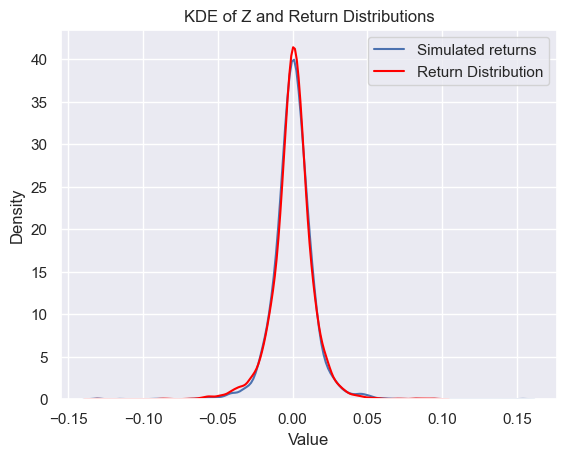

In [195]:
sns.kdeplot(Z, label='Simulated returns', color='blue')

# Plot the KDE for returns in the data_train DataFrame
sns.kdeplot(data_train["return"], label='Return Distribution', color='red')

# Add title and labels for clarity
plt.title('KDE of Z and Return Distributions')
plt.xlabel('Value')
plt.ylabel('Density')

# Show legend and plot
plt.legend()
plt.show()

In [193]:
#%pip install statsmodels

C:\Users\DEBA\AppData\Local\Temp\ipykernel_6200\349673878.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


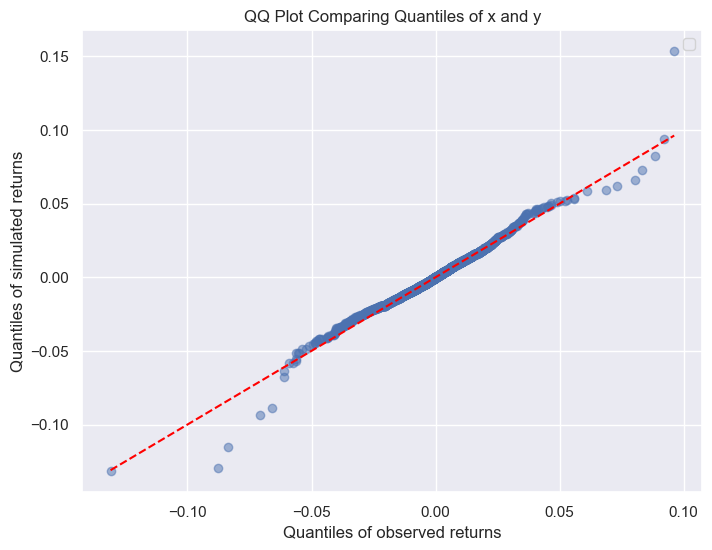

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


def quantile(df_observed, df_simulated):
    # Calculate the quantiles for both datasets
    quantiles_x = np.percentile(df_observed, np.linspace(0, 100, len(Z)))
    quantiles_y = np.percentile(df_simulated, np.linspace(0, 100, len(Z)))

    # Plot the QQ plot comparing the quantiles of x and y
    fig = plt.figure(figsize=(8, 6))
    plt.scatter(quantiles_x, quantiles_y, alpha=0.5)

    # Add the line y = x (ideal case if the distributions are identical)
    plt.plot([min(quantiles_x), max(quantiles_x)], [min(quantiles_x), max(quantiles_x)], color='red', linestyle='--')

    # Customize the plot
    plt.title('QQ Plot Comparing Quantiles of x and y')
    plt.xlabel('Quantiles of observed returns')
    plt.ylabel('Quantiles of simulated returns')
    plt.grid(True)
    plt.legend()
    return fig


In [202]:
Z.head()

,0
Date,
2008-10-15,0.003356
2008-10-16,-0.003231
2008-10-17,-0.002804
2008-10-20,-0.019848
2008-10-21,0.020786


In [ ]:
from var import Var
start_train, start_test, end_test  = "2008-10-15", "2022-07-26", "2024-06-11"

VaR = Var(ticker, start_date, end_date)
VaR.fit(start_train, start_test, end_test, alpha=0.99)